In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc,roc_curve

import os
from glob import glob

In [2]:
path='data'
csv_file='data/HAM10000_metadata.csv'

In [3]:
df=pd.read_csv(csv_file).set_index('image_id')
df.head()

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [4]:
df.dx=df.dx.astype('category',copy=True)
df['labels']=df.dx.cat.codes # Convert the labels to numbers
df['lesion']= df.dx.map(lesion_type_dict)
df.head()

,lesion_id,dx,dx_type,age,sex,localization,labels,lesion
image_id,,,,,,,,
ISIC_0027419,HAM_0000118,bkl,histo,80.0,male,scalp,2,Benign keratosis
ISIC_0025030,HAM_0000118,bkl,histo,80.0,male,scalp,2,Benign keratosis
ISIC_0026769,HAM_0002730,bkl,histo,80.0,male,scalp,2,Benign keratosis
ISIC_0025661,HAM_0002730,bkl,histo,80.0,male,scalp,2,Benign keratosis
ISIC_0031633,HAM_0001466,bkl,histo,75.0,male,ear,2,Benign keratosis


In [5]:
df.loc['ISIC_0027419','lesion']


'Benign keratosis '

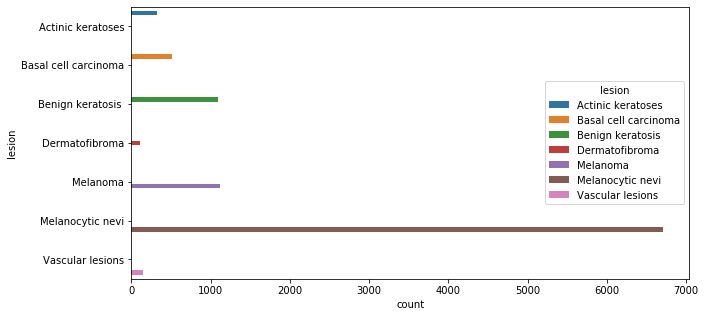

In [6]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
sns.countplot(y='lesion',data=df, hue="lesion",ax=ax1)

In [6]:
class CustomImageItemList(ImageList):
    def custom_label(self,df, **kwargs)->'LabelList':
        """Custom Labels from path"""
        file_names=np.vectorize(lambda files: str(files).split('/')[-1][:-4])
        get_labels=lambda x: df.loc[x,'lesion']
        #self.items is an np array of PosixPath objects with each image path
        labels= get_labels(file_names(self.items))
        y = CategoryList(items=labels)
        res = self._label_list(x=self,y=y)
        return res

In [8]:
def get_data(bs, size):
    train_ds = (CustomImageItemList.from_folder('data', extensions='.jpg')
                    .split_by_rand_pct(0.15)
                    .custom_label(df)
                    .transform(tfms=get_transforms(flip_vert=True),size=size)
                    .databunch(num_workers=2, bs=bs)
                    .normalize(imagenet_stats))
    return train_ds

In [9]:
data=get_data(64,224)


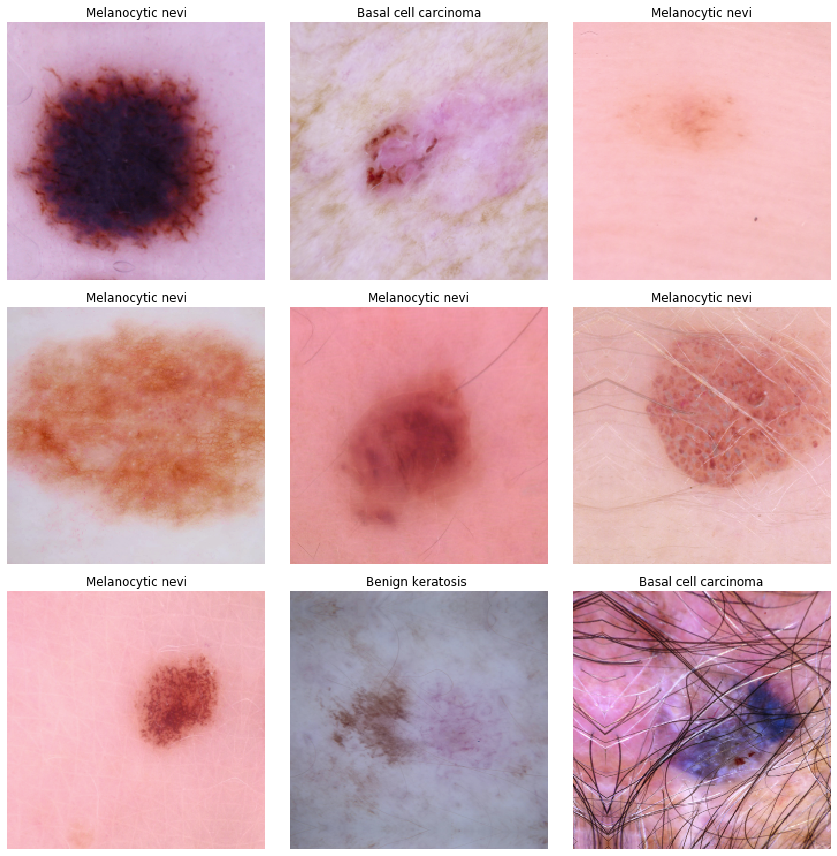

In [10]:
data.show_batch(rows=3)


In [11]:
learner=cnn_learner(data,models.resnet50,metrics=[accuracy], model_dir="/tmp/model/")


In [12]:
learner.loss_func=nn.CrossEntropyLoss()


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


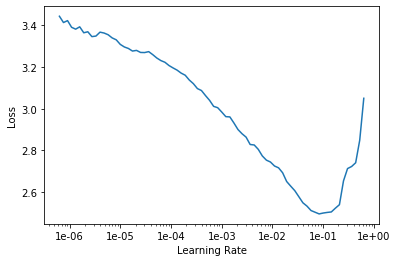

In [13]:
learner.lr_find()
learner.recorder.plot()

In [14]:
learner.fit_one_cycle(10, 3e-3)


epoch,train_loss,valid_loss,accuracy,time
0,0.842767,0.538132,0.828590,06:18
1,0.523892,0.407621,0.852887,06:14
2,0.452332,0.354323,0.872857,06:14
3,0.389666,0.356899,0.862373,06:14
4,0.341153,0.249814,0.901814,06:13
5,0.284022,0.189175,0.927276,06:13
6,0.243573,0.151351,0.943252,06:14
7,0.174666,0.122737,0.956565,06:13
8,0.151922,0.099304,0.962556,06:15
9,0.141897,0.093528,0.967715,06:13


In [15]:
learner.unfreeze()


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


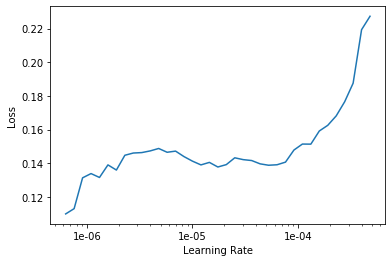

In [16]:
learner.lr_find()
learner.recorder.plot()

In [17]:
lr=1e-6
learner.fit_one_cycle(2, slice(3*lr,10*lr))


epoch,train_loss,valid_loss,accuracy,time
0,0.140503,0.085103,0.970045,06:14
1,0.126496,0.079913,0.971376,06:14


In [18]:
learner.save('stage-1')

In [19]:
interp = ClassificationInterpretation.from_learner(learner)


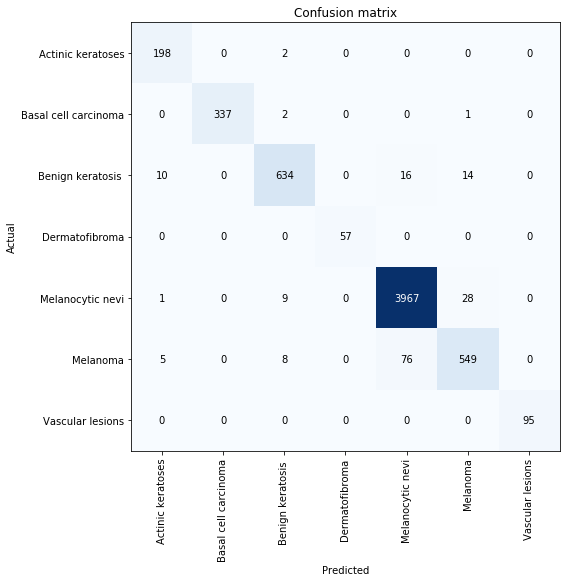

In [20]:
interp.plot_confusion_matrix(figsize=(10,8))


In [21]:
learner.export()

In [11]:
export_file_name = 'export.pkl'
path_ = Path("models")
learn = load_learner(path_, export_file_name)


In [12]:
img = open_image('data/ham10000_images_part_2/ISIC_0029886.jpg')

In [13]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category Melanocytic nevi